In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('alicante_co2.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21914 entries, 0 to 21913
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   21914 non-null  object 
 1   co2     21914 non-null  float64
dtypes: float64(1), object(1)
memory usage: 342.5+ KB


In [ ]:
df['fecha'] = pd.to_datetime(df['fecha'])

In [ ]:
df = df.set_index('fecha', drop=True)

In [ ]:
# Pasamos los datos a tipo trimestral (4 estaciones)
df = df.resample('Q').mean()

In [ ]:
df.head()

,co2
fecha,
1964-03-31,321.377778
1964-06-30,321.739121
1964-09-30,318.376957
1964-12-31,317.778152
1965-03-31,320.258111


In [ ]:
df.shape

(240, 1)

## QQ Plot

In [ ]:
from scipy import stats

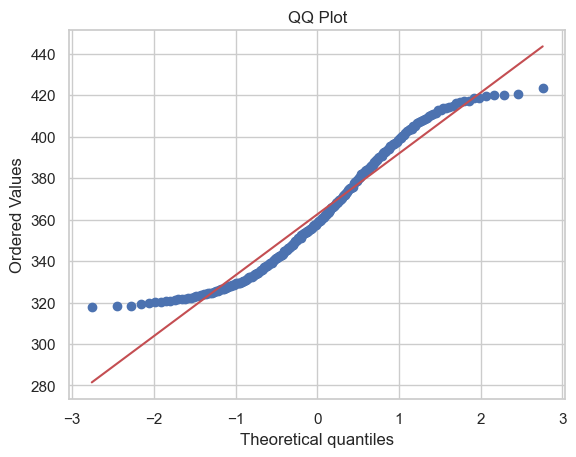

In [ ]:
data = df.co2

# Crear una figura con estilos de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico Q-Q con scipy y matplotlib
(stats.probplot(data, plot=plt))

# Añadir título y mostrar el gráfico
plt.title("QQ Plot", size = 12)
plt.show()

### Dividimos los datos en train y test

In [ ]:
# Seleccionamos tamaño de la muestra
size = int(len(df)*0.80)

In [ ]:
# Seleccionamos conjunto de train y test
df_train = df.iloc[:size]
df_test = df.iloc[size:]

### Visualización de Train y Test

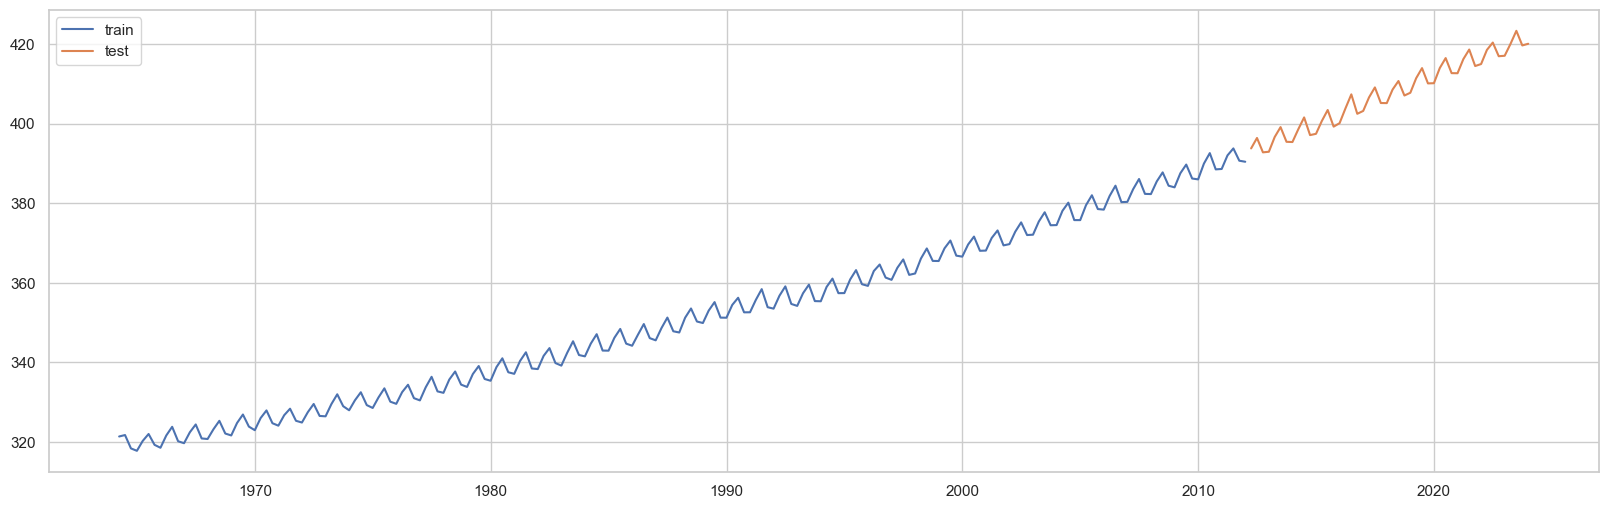

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(df_train.co2, label='train')
plt.plot(df_test.co2, label='test')
plt.legend()

In [ ]:
from pmdarima import auto_arima

In [ ]:
# Seleccionamos la variable a estudiar para train y test
train = df_train['co2']
test = df_test['co2']

In [ ]:
auto_arima_model = auto_arima(train,
                              start_p=0, d=0, start_q=0,
                              max_p=5, max_d=2, max_q=5,
                              start_P=0, D=2, start_Q=0,
                              max_P=5, max_D=2, max_Q=5,
                              m=4, seasonal=True, stepwise=True,
                              suppress_warnings=True, error_action='warn', trace=True,
                             random_state=6)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,2,0)[4]             : AIC=445.926, Time=0.09 sec
 ARIMA(1,0,0)(1,2,0)[4]             : AIC=278.886, Time=0.08 sec
 ARIMA(0,0,1)(0,2,1)[4]             : AIC=240.941, Time=0.13 sec
 ARIMA(0,0,1)(0,2,0)[4]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(1,2,1)[4]             : AIC=241.211, Time=0.16 sec
 ARIMA(0,0,1)(0,2,2)[4]             : AIC=239.449, Time=0.19 sec
 ARIMA(0,0,1)(1,2,2)[4]             : AIC=inf, Time=0.62 sec
 ARIMA(0,0,1)(0,2,3)[4]             : AIC=232.941, Time=0.25 sec
 ARIMA(0,0,1)(1,2,3)[4]             : AIC=234.127, Time=0.47 sec
 ARIMA(0,0,1)(0,2,4)[4]             : AIC=234.016, Time=0.78 sec
 ARIMA(0,0,1)(1,2,4)[4]             : AIC=235.761, Time=0.63 sec
 ARIMA(0,0,0)(0,2,3)[4]             : AIC=334.891, Time=0.14 sec
 ARIMA(1,0,1)(0,2,3)[4]             : AIC=152.814, Time=0.57 sec
 ARIMA(1,0,1)(0,2,2)[4]             : AIC=151.586, Time=0.39 sec
 ARIMA(1,0,1)(0,2,1)[4]             : AIC=203.967, Time

El modelo auto ARIMA (1, 0, 0) componentes no estacionales del modelo, indica que:

- El modelo utiliza 1 retardo en la parte autorregresiva (AR), p=1. Entendemos que el modelo utiliza el valor previo para el pronóstico.

- No se realiza diferenciación (I), d=0. Entendemos que no necesita diferenciación con lo que la serie es estacionaria.

- Media móvil(MA), q=0. Entendemos que el modelo no utiliza ningún término de media móvil.

(0, 2, 2)[4] componentes estacionales del modelo, indica que:

- No existen componentes autorregresivos estacionales(AR), P=0. No lo utiliza nuestro modelo.

- Se aplica al modelo una diferenciación (I) estacional de orden 2, D=2. La serie se diferencia 2 veces.

- Nuestro modelo utiliza 2 términos de media móvil estacional, Q=2.

- [4] es la estacionalidad trimestral que indicamos al inicio

In [ ]:
# Los mejores parámetros encontrados por auto_arima
best_order = auto_arima_model.order
best_seasonal_order = auto_arima_model.seasonal_order

print(f'Mejor modelo {best_order}{best_seasonal_order}')

Mejor modelo (1, 0, 0)(0, 2, 2, 4)


Con estos parámetros podemos continuar con el modelo 'SARIMAX'.

In [ ]:
import statsmodels.api as sm

In [ ]:
# Utilizamos el mejor modelo encontrado ARIMA en un modelo SARIMAX
sarimax_model = sm.tsa.statespace.SARIMAX(train,
                                          order=best_order,
                                          seasonal_order=best_seasonal_order)
sarimax_results = sarimax_model.fit(maxiter=200)

C:\Users\34610\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [ ]:
# Guardamos las predicciones
predictions = sarimax_results.predict(start=test.index[0], end=test.index[-1])

In [ ]:
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    co2   No. Observations:                  192
Model:             SARIMAX(1, 0, 0)x(0, 2, [1, 2], 4)   Log Likelihood                 -71.090
Date:                                Sat, 30 Mar 2024   AIC                            150.179
Time:                                        20:19:35   BIC                            163.039
Sample:                                    03-31-1964   HQIC                           155.391
                                         - 12-31-2011                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9820      0.020     49.899      0.000       0.943       1.021
ma.S.L4       -1.7626      0.058    -30.429      0.000      -1.876      -1.649
ma.S.L8        0.7823      0.057     13.723      0.000       0.671       0.894
sigma2         0.1140      0.013      8.538      0.000       0.088       0.140
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.17   Prob(JB):                         0.65
Heteroskedasticity (H):               0.92   Skew:                             0.01
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

•	Ar.Li 0.98 indica una fuerte correlación positiva con el valor que le precede.

•	ma.S.L4 y ma.S.L8 nos indican que los términos de la media móvil estacional son importantes para el modelo.

•	Sigma2 0.11 nos indica que el error del modelo es muy bajo.

•	Ljung-Box 0.17 sugiere que no existe autocorrelación significativa entre los residuos.

•	Jarque-Bera 0.65 nos da una buena señal indicando que los residuos se distribuyen de forma normal.

In [ ]:
# Convertimos 'df_test' a DataFrame
test_view = test.to_frame()

# Creamos un DataFrame para las predicciones
prediction = pd.DataFrame(predictions, index=df_test.index)
prediction.columns = ['prediction']

# Combinamos ambos DataFrames
pred_vs_test = test_view.join(prediction)

# Generamos la comparación entre la predicción y los datos
pred_vs_test['diff'] = pred_vs_test['co2'] - pred_vs_test['prediction']

In [ ]:
pred_vs_test.tail(20)

,co2,prediction,diff
fecha,,,
2019-03-31,411.421111,408.611059,2.810052
2019-06-30,413.957692,410.820782,3.136911
2019-09-30,410.117935,407.255303,2.862631
2019-12-31,410.166196,407.138717,3.027479
2020-03-31,413.977143,410.737900,3.239242
2020-06-30,416.480440,412.943130,3.537309
2020-09-30,412.695000,409.382113,3.312887
2020-12-31,412.671087,409.261750,3.409337
2021-03-31,416.218778,412.870941,3.347836


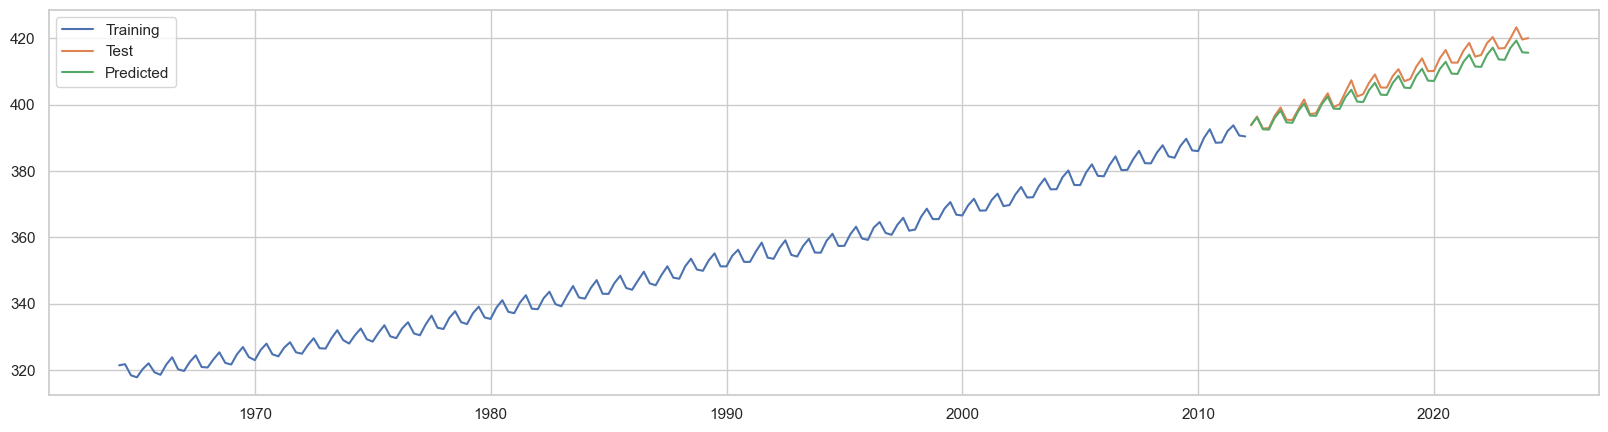

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

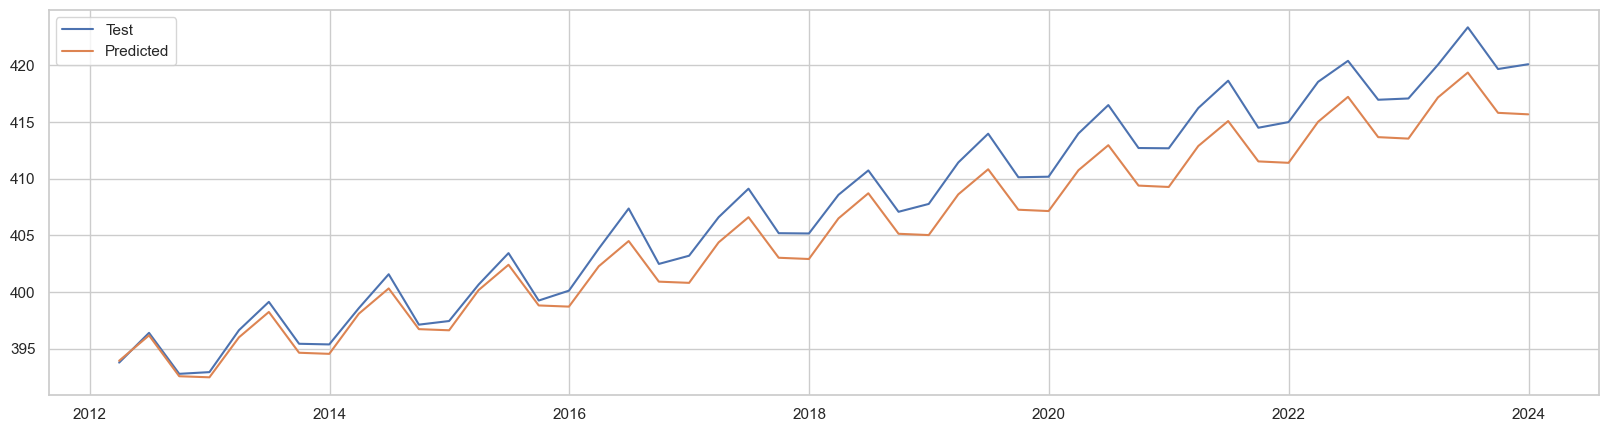

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
from sklearn.metrics import r2_score

RMSE (Root Mean Squared Error) mide la diferencia entre los valores de la predicción y los valores reales penalizando los errores grandes al elevar todos los valores al cuadrado.

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test, prediction['prediction'], squared=False)
print(f'Las predicciones se desvían en un promedio de {round(rmse, 2)} grados sobre la temperatura real')

Las predicciones se desvían en un promedio de 2.5 grados sobre la temperatura real


MAE (Mean Absolute Error) mide la diferencia entre los valores de la predicción y los valores reales sin penalizar los errores como el modelo anterior.

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, prediction['prediction'])
print(f'Las predicciones se desvían una media de {round(mae, 2)} grados sobre la temperatura real')

Las predicciones se desvían una media de 2.17 grados sobre la temperatura real



r2 (R-squared) mide la proporción de la varriabilidad en la variable dependiante que es predecible a partir de la variable independiente.

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(test, prediction['prediction'])
print(f'El modelo puede explicar el {(round(r2,4))*100}% de los datos de prueba')

El modelo puede explicar el 91.56% de los datos de prueba


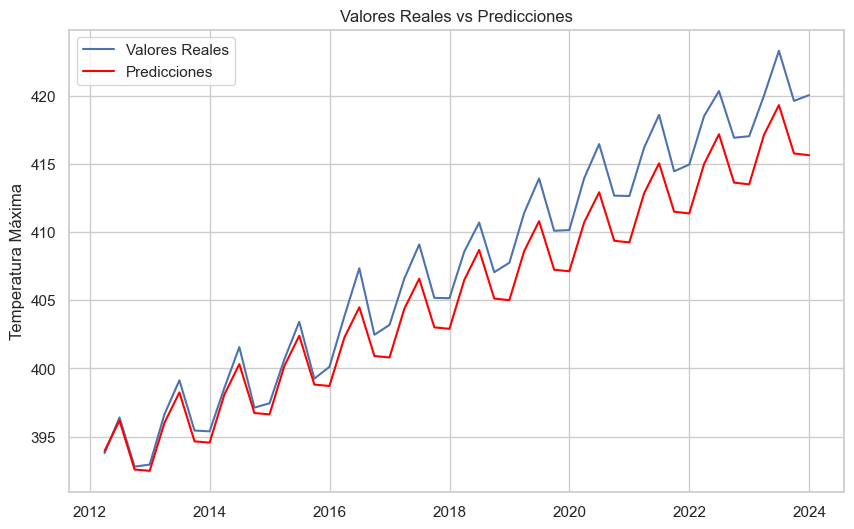

In [ ]:
# Compsrsmod rn uns gráfica los valores reales vs las predicciones
plt.figure(figsize=(10, 6))
plt.plot(test, label='Valores Reales')
plt.plot(test.index, predictions, color='red', label='Predicciones')
plt.title('Valores Reales vs Predicciones')
plt.ylabel('Temperatura Máxima')
plt.legend()
plt.show()

### Cálculos hasta el año 2040

In [ ]:
# Generamos fechas hasta el 2100
future_dates = pd.date_range(start=df.index[-1], periods=4 * (2100 - df.index[-1].year) + 1, freq='Q')

In [ ]:
# Generamos la predicción a futuro del modelo entrenado
future_predictions = sarimax_results.predict(start=future_dates[0], end=future_dates[-1])

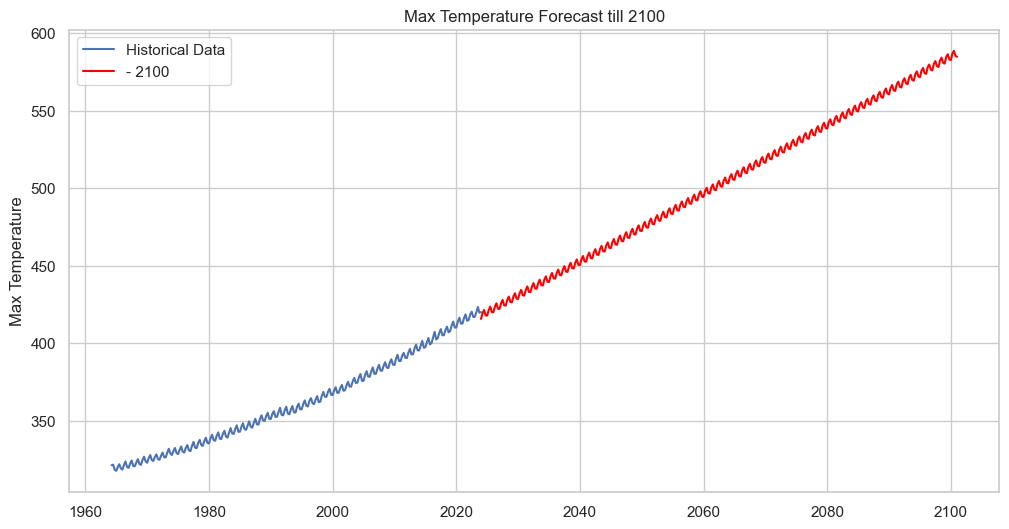

In [ ]:
# Visualizamos el gráfico
plt.figure(figsize=(12, 6))
plt.plot(df['co2'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='- 2100', color='red')
plt.title('Max Temperature Forecast till 2100')
plt.ylabel('Max Temperature')
plt.legend()
plt.show()

In [ ]:
co_future = pd.DataFrame(future_predictions, index=future_dates)
co_future = co_future.rename_axis('fecha')

In [ ]:
co_future = co_future.rename(columns={'predicted_mean': 'co2'})
df_co2_1964_2100 = pd.concat([df, co_future])#, ignore_index=True)

In [ ]:
co_future.to_csv('co_future.csv')

<Axes: xlabel='fecha'>

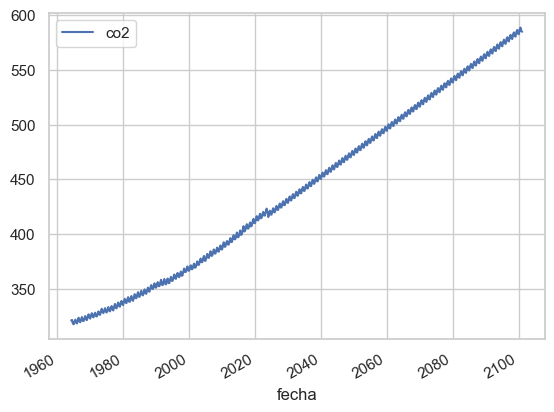

In [ ]:
df_co2_1964_2100.plot()

In [ ]:
df_co2_1964_2100.to_csv('df_co2_1964_2100.csv')